# Posterior plots

In this notebook we plot the posterior distributions resulting from the analyses described in section 4 of [Donald-McCann, Koyama, and Beutler (2022)](https://arxiv.org/abs/2202.07557).

We start by importing all the required modules and packages. We also specify the path to the repo.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import getdist
from getdist import plots, MCSamples
from matplotlib.colors import TABLEAU_COLORS
import glob
import matplotlib.patches as mpatches
from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde

path_to_repo = "/Users/jamie/Desktop/GitHubProjects/matryoshka_II_paper/"

Next we specify the redshift. It can be either $0.51$ or $0.61$ for this notebook.

In [2]:
redshift = 0.61

We next define a few functions that save us from repeating blocks of code. The first, `make_corner`, will produce a corner plot using `getdist`. 

In [3]:
def make_corner(samples_list, inflated=None, savev=None):
    '''
    Produces corner plot with getdist.
    
    Args:
        samples_list (list) : List of ``MCSamples`` objects.
        inflated (MCSamples) : ``MCSamples`` object corresponding to proposal distribution used for importance sampling.
         Will be plotted in light grey. Default is ``None``.
        savev (int) : Volume of covariance used to compute the posteriors represent by the samples in ``samples_list``.
         this will be used in the file name when saving. If ``None`` plot will not be saved. Default is ``None``.
    '''
    g = plots.get_subplot_plotter(width_inch=9)

    g.settings.axes_fontsize = 12.5
    #g.settings.num_plot_contours = 1
    if inflated is None:
        g.triangle_plot(samples_list, filled=False, contour_colors=list(TABLEAU_COLORS.keys()), contour_lws=1.5)
    else:
        g.triangle_plot([inflated]+samples_list,
                        filled=[True]+len(samples_list)*[False],
                        contour_colors=['lightgrey']+list(TABLEAU_COLORS.keys()), contour_lws=1.5)

    # Note: This loop of axes is not really needed.
    # GetDist has functionality for adding truths.
    for i in range(truths.shape[0]):
        for j in range(truths.shape[0]):
            if i == j:
                g.subplots[i,j].axvline(truths[i], color='gray', ls='--')
            elif j < i:
                g.subplots[i,j].axvline(truths[j], color='gray', ls='--')
                g.subplots[i,j].axhline(truths[i], color='gray', ls='--')
                
    if savev is not None:
        g.export(path_to_repo+f"plots/corner_pybird--z-{redshift}--Vi-{savev}--all.pdf")

The next function, `make_IS`, creates `MCSamples` objects with importance sampled chains.

In [4]:
def make_IS(weights, chain, limit=None):
    '''
    Importance sample chain with getdist.
    
    Args:
        weights (array) : Array containing the importance weights.
        chain (array) : Array containing chain samples. Mcust have same shape as ``weights``.
        limit (int) : Limit the number of samples used to ``limit``. Can be useful to examine noise in the chain.
         Default is ``None``.
    '''
    
    if limit is not None:
        samples = MCSamples(samples=chain[:limit],
                                   names=names, labels=labels, weights=weights[:limit], label="PyBird IS",
                                   ranges=bounds_dict)
        samples.updateSettings({'smooth_scale_2D': 0.4, 'smooth_scale_1D':0.2})
    else:
        samples = MCSamples(samples=chain,
                           names=names, labels=labels, weights=weights, label="PyBird IS",
                           ranges=bounds_dict)
        samples.updateSettings({'smooth_scale_2D': 0.4, 'smooth_scale_1D':0.2})
    return samples

Next we define the labels and names of each of the parameters in the chain files. As well as the limits of any uniform priors.

In [5]:
# Lables will be displayed on plots.
labels = [r"\omega_c",r"h",r"A_s", r"b_1", r"c_2", r"b_3", r"c_{ct}", r"c_{r,1}",
          r"c_{\epsilon,1}", r"c_{\epsilon,quad}"]

# Names can be used to access samples for given parameters.
names = ["omega_c","h","As", "b1", "c2", "b3", "cct", "cr1", "ce1", "cq"]

# Limits of uniform priors.
bounds_dict = {"omega_c": [0.109988, 0.129229], 
               "h": [0.57451438, 0.74766042], 
               "As": [2.77885117, 3.32142323], 
               "b1": [0., 4.], 
               "c2": [-4., 4.]}

We now load the chain samples and importance weights for each of the volumes considered.

In [6]:
Vlist = [1000, 2000, 3000, 4000, 5000]

# Each element of samples_list will be an MCSamples object with the chain.
samples_list = []

# Each element of IS_list will be the importance sampled chain.
IS_list = []

# Loop over volumes.
for Vi in Vlist:
    samples_list.append(MCSamples(samples=np.load(glob.glob(path_to_repo+f"results/chain*z-{redshift}*V-{Vi}*.npy")[0]),
                                  names=names, labels=labels, label=f"EFTEMU $V_s = {str(Vi)}^3$", 
                                  ranges=bounds_dict))
    samples_list[-1].updateSettings({'smooth_scale_2D': 0.4, 'smooth_scale_1D':0.2})
    
    # If the volume is < 2000 the proposal uses the same covariance as the target.
    # If the volume is > 2000 the proposal uses lower volime covaraince.
    if Vi>2000:
        Vc = Vi-1000
    else:
        Vc = Vi
    
    # Load weights
    weights_file = glob.glob(path_to_repo+f"results/weights*{redshift}*{Vc}*{Vi}*all.npy")[0]
    weights = np.load(weights_file)
    
    # Normalise such that the weights sum to 1.
    weights = weights/weights.sum()

    # Load samples corresponding to weights.
    chain = np.load(glob.glob(path_to_repo+f"results/chain*z-{redshift}*V-{Vc}*--shuffled.npy")[0])[-weights.shape[0]:]
    
    # Construct importance sampled chain.
    IS_list.append(make_IS(weights, chain))

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


Removed no burn in
Removed no burn in
Removed no burn in


Before doing any plotting we define the true values used to generate the mocks.

In [7]:
cosmo_true = np.array([0.11933, 0.02242, 0.6766, 3.047, 0.9665])
bs_CMASS = np.array([2.22, 1.2, 0.1, 0.0, 0.4, -7.7, 0., 0., 0., -3.7])
truths = np.concatenate([cosmo_true[[0,2,3]], bs_CMASS[[0,1,2,4,5,7,9]]])

Now we produce a corner plot for each volume considered. We plot the chain samples and importance samples. In cases where the proposal has a different volume we plot this too.

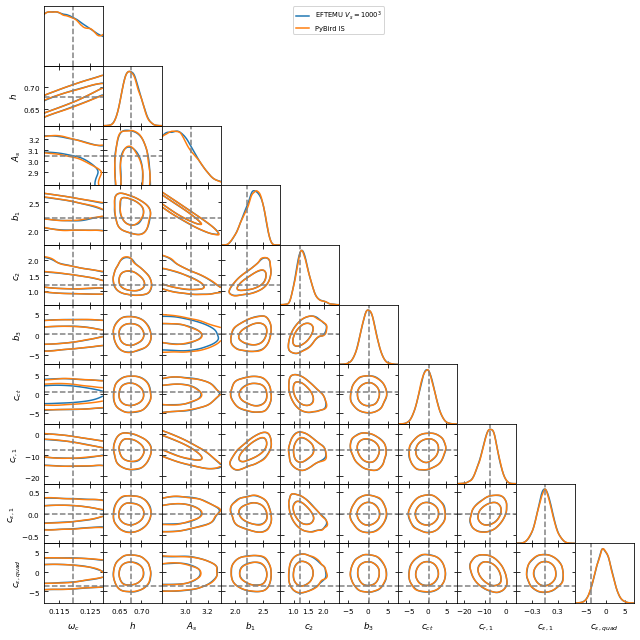

In [8]:
make_corner([samples_list[0], IS_list[0]], savev=1000)

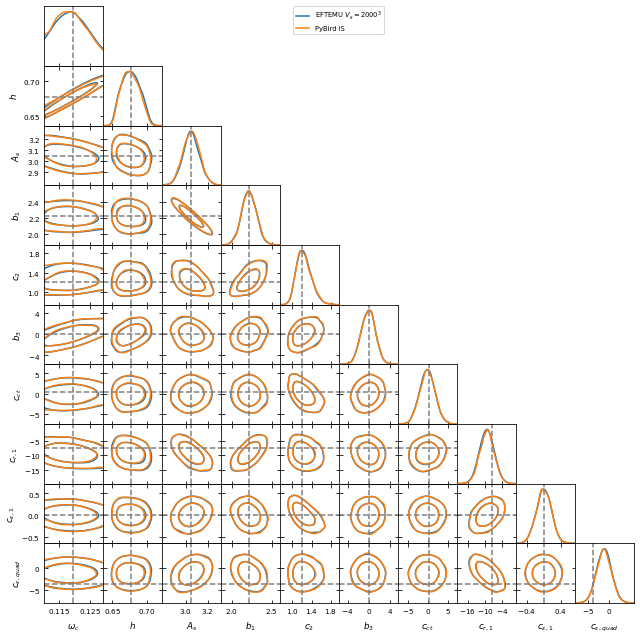

In [9]:
make_corner([samples_list[1], IS_list[1]], savev=2000)

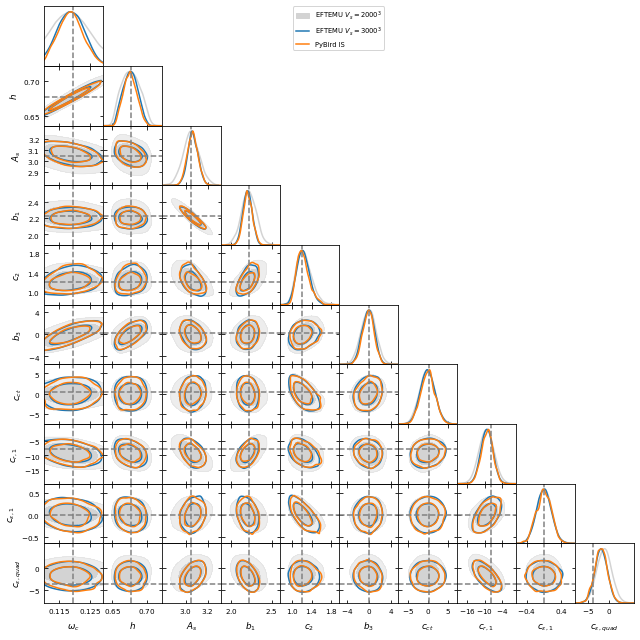

In [10]:
make_corner([samples_list[2], IS_list[2]], inflated=samples_list[1], savev=3000)

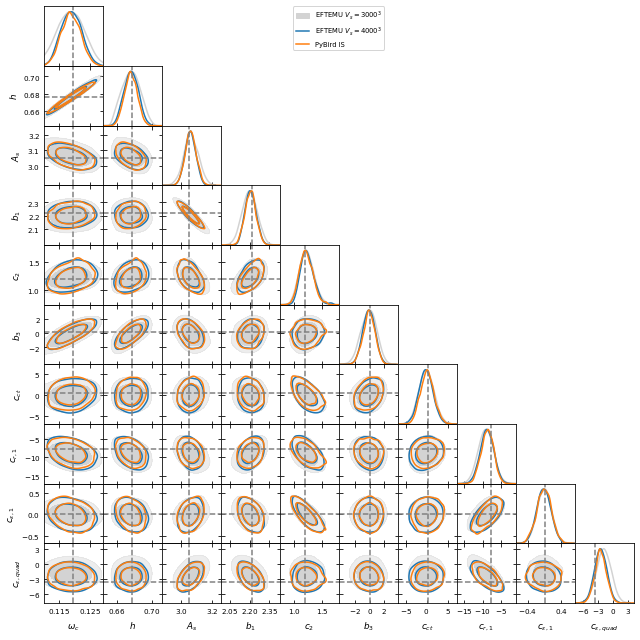

In [11]:
make_corner([samples_list[3], IS_list[3]], inflated=samples_list[2], savev=4000)

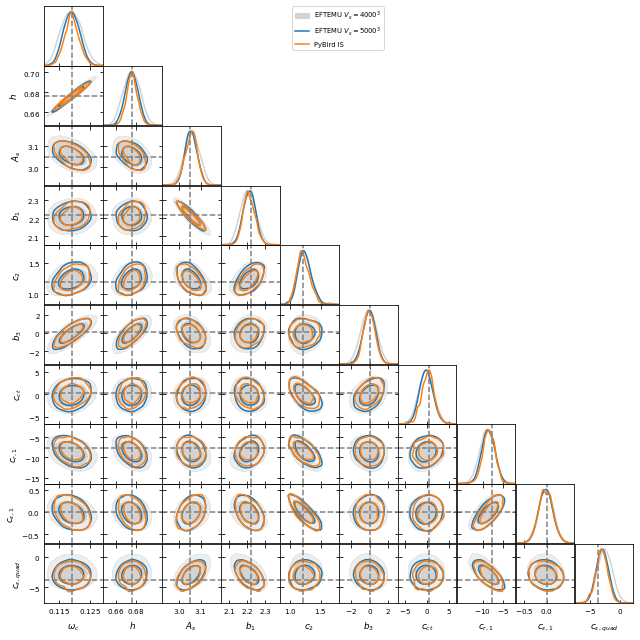

In [12]:
make_corner([samples_list[4], IS_list[4]], inflated=samples_list[3], savev=5000)

We now compare the emulator and `PyBird` posteriors with equations A1 and A2 from [Donald-McCann, Koyama, and Beutler (2022)](https://arxiv.org/abs/2202.07557).

In [13]:
# Lists will store the comparison statistics for each parameter at each volume.
# These will be used to produce the violin plot below.
marg_stats_pybird_allV = []
marg_stats_emu_allV = []

# Loop over volumes.
for j, Vj in enumerate([1000,2000,3000,4000,5000]):
    print("++++++++++++++++")
    print(f"V={Vj}^3")
    
    # Lists will store the stats for each parameter at Vi.
    marg_stats_pybird_Vi = []
    marg_stats_emu_Vi = []
    
    # Loop over the parameters of interest.
    for param_i in ['omega_c', 'h', 'As', 'b1']:
        xs = np.linspace(bounds_dict[param_i][0], bounds_dict[param_i][1],1000)

        # Extract the density estimator from getdist
        pybird_kde = IS_list[j].get1DDensity(param_i)
        emu_kde = samples_list[j].get1DDensity(param_i)

        # Evaluate the PyBird posterior over the parameter range.
        pybird_pdf = pybird_kde.Prob(xs)
        
        # Calculate the CDF
        pybird_cdf = np.cumsum(pybird_pdf)
        pybird_cdf /= pybird_cdf.max()
        
        # Evaluate the CDF to find to 0.16, 0.5, and 0.84 qunatiles.
        pybird_cdf_int = interp1d(pybird_cdf, xs)
        pybird_marg_stats = pybird_cdf_int([0.16,0.5,1-0.16])

        # Same procedure as above but with the emulator posterior.
        emu_pdf = emu_kde.Prob(xs)
        emu_cdf = np.cumsum(emu_pdf)
        emu_cdf /= emu_cdf.max()
        emu_cdf_int = interp1d(emu_cdf, xs)
        emu_marg_stats = emu_cdf_int([0.16,0.5,1-0.16])

        # Print comparison stats.
        print(f"Mean_shift {param_i}: ",(emu_marg_stats[1]-pybird_marg_stats[1])/((pybird_marg_stats[-1]-pybird_marg_stats[0])*0.5))
        print(f"Width ratio {param_i}: ", (emu_marg_stats[-1]-emu_marg_stats[0])/(pybird_marg_stats[-1]-pybird_marg_stats[0]))
        
        marg_stats_pybird_Vi.append(pybird_marg_stats)
        marg_stats_emu_Vi.append(emu_marg_stats)
        
    marg_stats_pybird_allV.append(np.stack(marg_stats_pybird_Vi))
    marg_stats_emu_allV.append(np.stack(marg_stats_emu_Vi))   
    

++++++++++++++++
V=1000^3
Mean_shift omega_c:  0.014208078693091227
Width ratio omega_c:  0.9944926866277516
Mean_shift h:  0.019113559104129558
Width ratio h:  1.000473415326132
Mean_shift As:  0.03597189927375348
Width ratio As:  0.9856102890238891
Mean_shift b1:  -0.0387622886723563
Width ratio b1:  0.9910112923855737
++++++++++++++++
V=2000^3
Mean_shift omega_c:  0.0475110280612894
Width ratio omega_c:  1.0072198220055306
Mean_shift h:  0.060832843455253124
Width ratio h:  1.0514359806117506
Mean_shift As:  -0.023622553056328845
Width ratio As:  0.9741464103670118
Mean_shift b1:  -0.014007015902504269
Width ratio b1:  0.990713208668837
++++++++++++++++
V=3000^3
Mean_shift omega_c:  0.026507594257978852
Width ratio omega_c:  1.061714513696999
Mean_shift h:  0.0540021644386993
Width ratio h:  1.1071986736008148
Mean_shift As:  0.020679475710709917
Width ratio As:  0.9688325574907521
Mean_shift b1:  -0.048523965106443384
Width ratio b1:  1.0103033295214254
++++++++++++++++
V=4000^3
Me

Finally we produce the violin plot. We start by extracting the extremes of the distributions for all the volumes.

In [14]:
mins = np.vstack([samples_list[i].samples for i in range(len(samples_list))]).min(axis=0)
maxs = np.vstack([samples_list[i].samples for i in range(len(samples_list))]).max(axis=0)

Next we redefine the prior (there is certainly a way of using the prior as defined with `getdist` but using `numpy` is simple enough).

In [15]:
path_to_train = path_to_repo+"data/training/"
cosmos = np.load(path_to_train+"cosmologies/eft_cosmologies_noDQ1.npy")
priors = np.vstack([cosmos.min(axis=0), cosmos.max(axis=0)]).T
priors = priors[[0,2,3]]
priors = np.vstack([priors, np.array([0.,4.])])
priors[0,0] = 0.109988
priors[0,1] = 0.129229

Now we actually produce the plot.

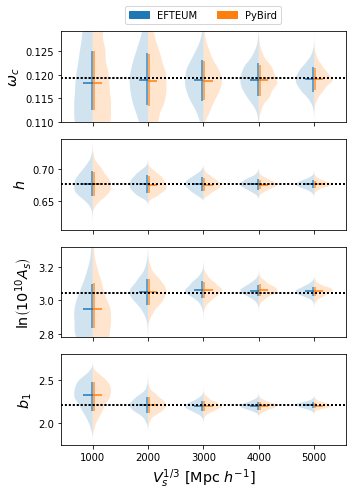

In [16]:
vols = [1000, 2000, 3000, 4000, 5000]
labels = [r"$\omega_c$", r"$h$", r"$\ln{\left(10^{10}A_s\right)}$", r"$b_1$"]

# Define figure to have 4 rows.
fig, ax = plt.subplots(4,1,sharex=True, figsize=(5,7))

# Loop over rows of the figure.
for j, (axj, pi) in enumerate(zip(ax, ['omega_c', 'h', 'As', 'b1'])):
    
    # Loop over the volumes.
    for i in range(len(samples_list)):
        
        # Define values at which the pdf will be evaluated.
        xs = np.linspace(mins[j], maxs[j], 300)
        
        # Evaluate emulator pdf
        emukde = samples_list[i].get1DDensity(pi)
        emupdf = emukde.Prob(xs)
        
        # Evaluate PyBird pdf
        ISkde = IS_list[i].get1DDensity(pi)
        ISpdf = ISkde.Prob(xs)
        
        # Plot pdfs
        axj.fill_betweenx(xs, ISpdf/ISpdf.max()+i*3, x2=i*3, fc='tab:orange', alpha=0.2, zorder=0)
        axj.fill_betweenx(xs, -emupdf/emupdf.max()+i*3, x2=i*3, fc='tab:blue', alpha=0.2, zorder=0)
        
        # Extract current ylimits for the row.
        ylim = axj.get_ylim()
        
        # Make sure the ylimits are not greater than the prior.
        axj.set_ylim(max(priors[j,0], ylim[0]), min(priors[j,1], ylim[1]))
        
        # Add truth
        axj.axhline(truths[j], linestyle=':', color='k')
        
        # Add 1sigma error bar.
        axj.vlines(i*3-0.05, marg_stats_emu_allV[i][j,0], marg_stats_emu_allV[i][j,2], color='tab:blue',
                   zorder=1, alpha=0.8)
        axj.vlines(i*3+0.05, marg_stats_pybird_allV[i][j,0], marg_stats_pybird_allV[i][j,2], color='tab:orange', zorder=1,
                   alpha=0.8)
        
        # Add median line.
        axj.hlines(marg_stats_emu_allV[i][j,1], i*3-0.5, i*3, color='tab:blue')
        axj.hlines(marg_stats_pybird_allV[i][j,1], i*3, i*3+0.5, color='tab:orange')
        
        axj.set_ylabel(labels[j], fontsize='x-large')


ax[-1].set_xlabel(r"$V_s^{1/3}\ [\mathrm{Mpc}\ h^{-1}]$", fontsize='x-large')

# Alter xticks to reflect the volumes.
plt.xticks(ticks=np.arange(len(samples_list))*3, labels=vols)

# Great stack answer for putting legend outside plot
# https://stackoverflow.com/questions/4700614/how-to-put-the-legend-outside-the-plot
legend_patches = [mpatches.Patch(label='EFTEUM', color='tab:blue'), mpatches.Patch(label='PyBird', color='tab:orange')]
ax[0].legend(handles=legend_patches, loc='lower center', bbox_to_anchor=(0,1.02,1,0.2), ncol=2)

plt.tight_layout()

plt.savefig(path_to_repo+f"plots/violins--z-{redshift}--w_pybird.png", dpi=300)